## This note is used to show training in RFDiffusion


In [1]:
# sample a structure from PDB
import requests
import os

def fetch_pdb(pdb_id, save_dir="pdb_files"):
    """
    Fetches a PDB file from the RCSB Protein Data Bank and saves it locally.
    
    Args:
        pdb_id (str): The PDB ID of the structure to fetch (e.g., "1HHO").
        save_dir (str): Directory to save the PDB file. Default is 'pdb_files'.
        
    Returns:
        str: Path to the saved PDB file, or None if download failed.
    """
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Construct the URL for the PDB file
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    save_path = os.path.join(save_dir, f"{pdb_id}.pdb")
    
    try:
        # Download the PDB file
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx and 5xx)
        
        # Write the file to the save directory
        with open(save_path, "wb") as pdb_file:
            for chunk in response.iter_content(chunk_size=1024):
                pdb_file.write(chunk)
        
        print(f"PDB file {pdb_id} successfully downloaded to {save_path}")
        return save_path
    except requests.exceptions.RequestException as e:
        print(f"Failed to download PDB file {pdb_id}: {e}")
        return None

# Example usage:
pdb_id = "1UBQ"  # Replace with your desired PDB ID
fetch_pdb(pdb_id)


PDB file 1UBQ successfully downloaded to pdb_files/1UBQ.pdb


'pdb_files/1UBQ.pdb'

In [32]:
# convert pdb to numpy 
import numpy as np

import numpy as np
import torch

def pdb_to_xyz_n_ca_c(pdb_file):
    """
    Extracts N, CA, and C atom coordinates from a PDB file and converts them to a NumPy array.
    
    Args:
        pdb_file (str): Path to the PDB file.
        
    Returns:
        np.ndarray: A NumPy array with shape (N, 3), where N is the number of selected atoms.
                    Each row contains [x, y, z] coordinates for N, CA, and C atoms.
    """
    coordinates = []
    
    with open(pdb_file, 'r') as file:
        for line in file:
            if line.startswith("ATOM") or line.startswith("HETATM"):
                atom_name = line[12:16].strip()  # Extract atom name (columns 13-16)
                if atom_name in {"N", "CA", "C"}:
                    # Extract x, y, z coordinates from columns 31-38, 39-46, 47-54 (1-indexed)
                    x = float(line[30:38].strip())
                    y = float(line[38:46].strip())
                    z = float(line[46:54].strip())
                    coordinates.append([x, y, z])
    
    # Convert list of coordinates to a NumPy array
    xyz_array = np.array(coordinates)
    return xyz_array

# Example usage:
pdb_file_path = 'pdb_files/1UBQ.pdb'  # Replace with the path to your PDB file
arr = pdb_to_xyz_n_ca_c(pdb_file_path)

# Reshaping the array to shape (n, 3, 3)
xyz = torch.tensor(arr)

# Reshape the tensor to shape (228//3, 3, 3)
xyz =xyz.view(-1, 3, 3)

# Print or save the resulting XYZ array
print("XYZ Array Shape:", xyz.shape)
#print(xyz_array)



XYZ Array Shape: torch.Size([76, 3, 3])


In [5]:
import sys
sys.path.append('/home/yunyao/RFdiffusion/rfdiffusion')

from util import rigid_from_3_points

In [33]:
# extract ca and r0 as ground truth
#xyz = xyz - xyz[:, 1, :].mean(dim=0)
xyz = xyz - xyz[:, 1, :].mean(dim=0)

if torch.is_tensor(xyz):
        xyz = xyz.numpy()
N = torch.from_numpy(xyz[None, :, 0, :])
Ca = torch.from_numpy(xyz[None, :, 1, :])  # [1, num_res, 3, 3]
C = torch.from_numpy(xyz[None, :, 2, :])

# scipy rotation object for true coordinates
R_true, Ca = rigid_from_3_points(N, Ca, C)
R_true = R_true[0]
Ca = Ca[0]

#xyz = xyz - xyz[:, 1, :].mean()  # center the protein to origin
print(R_true.shape, Ca.shape)


torch.Size([76, 3, 3]) torch.Size([76, 3])


In [ ]:
from diffusion import IGSO3

T=200
min_sigma=0
max_sigma=1
min_b=0
max_b=1
cache_dir='./cache'

# rotation noise linear schedulear sigma(t) = sigma_min + (t/T)*beta_min + 1/2(t/T)^2(beta_max-beta_min)
# sigma_min = 0.02, beta_min =1.06  beta_max=1.77
# rotation noise log schedular  log(sigma(t))= logsigma_min + t/T * (log(sigma_max)-log(sigma_min))

# in the SI, it seems the linear one is used and max_sigma is not used
test = IGSO3(T=T,
        min_sigma=0.02,
        max_sigma=1,
        min_b=1.06,
        max_b=1.77,
        cache_dir=cache_dir,
        num_omega=1000,
        schedule="linear",
        L=2000)

In [22]:
# now visulaization  rotatio noise schedule
print(test.igso3_vals['cdf'].shape)  #(num_sigma,  num_omega)
#test.igso3_vals.keys()
#test.igso3_vals['discrete_sigma'].shape
#test.igso3_vals['discrete_omega'].shape


(500, 1000)


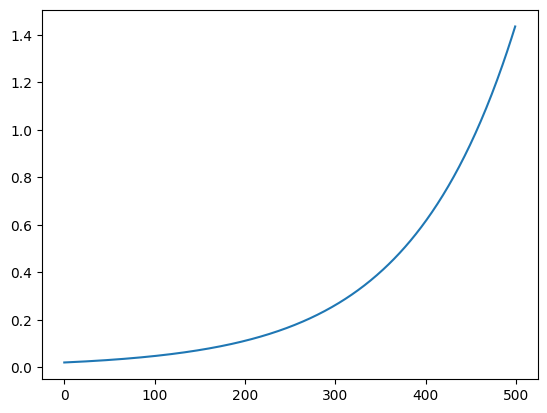

In [ ]:
test.discrete_sigma
import matplotlib.pyplot as plt
plt.plot(test.discrete_sigma)  # agree with sigma(t) = sigma_min + (t/T)*beta_min + 1/2(t/T)^2(beta_max-beta_min)

In [26]:
# g(t)= d/dt( sigma(t)^2)
test.g(0.4)

tensor(1.1602)

In [28]:
# import the translation diffuser
from diffusion import EuclideanDiffuser
# translation noise schedular beta(t) = beta_min + (beta_max-beta_min)*t/T
# in the paper beta_max=0.07, beta_min=0.01
trans_test=EuclideanDiffuser(T=T,
        b_0=0.01,
        b_T=0.07,
        schedule_type="linear")

In [ ]:
# now perturb the structure one translation one rotation
diffused_T, deltas = trans_test.diffuse_translations(
            torch.tensor(xyz[:, :3, :]).clone(), diffusion_mask=None
        )
print(diffused_T.shape)
print(deltas.shape) # ca cooridnate difference


torch.Size([76, 200, 3, 3])
torch.Size([76, 200, 3])


In [38]:
diffused_frame_crds, diffused_frames = test.diffuse_frames(
           torch.tensor(xyz[:, :3, :]).clone(), diffusion_mask=None, t_list=None
        )

In [39]:
print(diffused_frame_crds.shape)

(76, 200, 3, 3)
